In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
import os
import json
import random
import cv2
from tqdm import tqdm  # For displaying a progress bar
import matplotlib.pyplot as plt
import shutil


from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances

Define Dataset Paths

In [2]:
# Paths
dataset_dir = "/kaggle/input/dataset/HRSID_jpg/HRSID_JPG"
train_json = os.path.join(dataset_dir, "annotations/train2017.json")
image_dir = os.path.join(dataset_dir, "JPEGImages")
val_json = os.path.join(dataset_dir, "annotations/test2017.json")

Register Datasets

In [3]:
register_coco_instances("my_dataset_train", {}, train_json, image_dir)
register_coco_instances("my_dataset_val", {}, val_json, image_dir)

Get metadata

In [4]:
ship_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

Visualize Some Training Samples

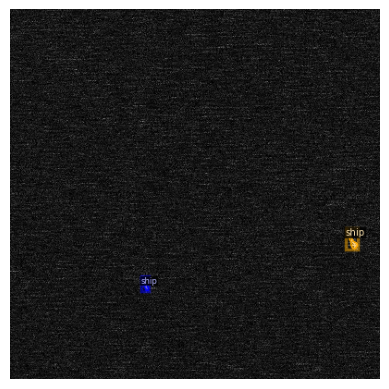

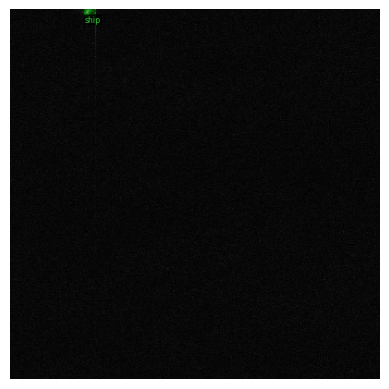

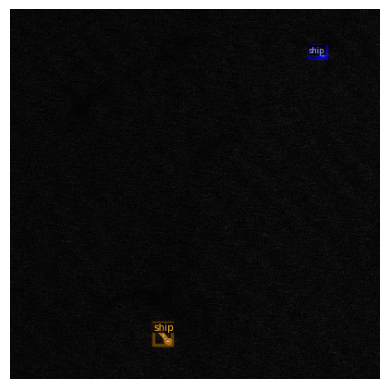

In [6]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ship_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

Configure the Model and Training Parameters
Train the Model

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set dataset train and test sets
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE = "cuda"  # Or "cpu" if you don't have a GPU


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Evaluate the Model

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create evaluator
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Evaluate model
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
print(metrics)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.

Visualize Predictions on Example Image

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

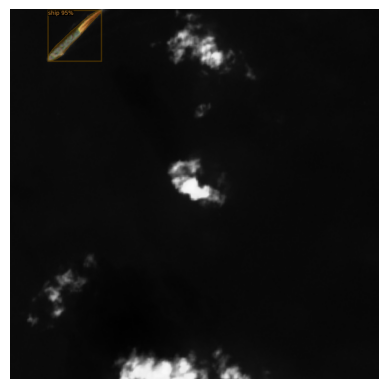

In [15]:
# Path to the image you want to analyze
strait_image_path = "/kaggle/input/dataset/strait_images/strait_images/2018/week_06/image_2018-02-05_56.330998_26.561534.png"

# Load the configuration and the trained model weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Update the configuration with your settings
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the trained model weights
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class ('ship')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set a custom testing threshold
cfg.MODEL.DEVICE = "cuda"  # Use GPU for inference if available

# Initialize the predictor with the trained model
predictor = DefaultPredictor(cfg)

# Load the image
img = cv2.imread(strait_image_path)

# Make predictions
outputs = predictor(img)

# Visualize the predictions
v = Visualizer(img[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image with predictions
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()


process all images in the specified folder and save the outputs

In [18]:
# Set up the paths
input_folder = "/kaggle/input/dataset/strait_images/strait_images/2018/week_01"
output_folder = "/kaggle/working/output_images"  # Output folder for the processed images
os.makedirs(output_folder, exist_ok=True)

# Load the configuration and the trained model weights
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Update the configuration with your settings
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the trained model weights
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class ('ship')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # Set a custom testing threshold
cfg.MODEL.DEVICE = "cuda"  # Use GPU for inference if available

# Initialize the predictor
predictor = DefaultPredictor(cfg)

# Initialize a counter for total objects above the threshold across all images
total_objects_above_threshold = 0

# Process all images in the input folder
for image_name in tqdm(os.listdir(input_folder)):
    # Ensure the file is an image
    if image_name.endswith((".png", ".jpg", ".jpeg")):
        # Load the image
        image_path = os.path.join(input_folder, image_name)
        img = cv2.imread(image_path)
        
        # Make predictions
        outputs = predictor(img)
        
        # Count the number of objects above the threshold
        instances = outputs["instances"]
        scores = instances.scores  # Confidence scores
        num_objects_above_threshold = (scores > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST).sum().item()
        
        # Add to the total count
        total_objects_above_threshold += num_objects_above_threshold
        
        # Visualize the predictions
        v = Visualizer(img[:, :, ::-1],
                       metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                       scale=0.8, 
                       instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
        )
        out = v.draw_instance_predictions(instances.to("cpu"))
        
        # Save the output image
        output_image_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_image_path, out.get_image()[:, :, ::-1])

# Print the total count of objects across all images
print(f"Total objects detected above the threshold across all images: {total_objects_above_threshold}")

print(f"Processing complete. All images saved to {output_folder}")

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Total objects detected above the threshold across all images: 37
Processing complete. All images saved to /kaggle/working/output_images


zip the folder for easier download

In [19]:
# Path to the output folder and the zip file
output_folder = "/kaggle/working/output_images"
zip_file = "/kaggle/working/output_images.zip"

# Zip the directory
shutil.make_archive(output_folder, 'zip', output_folder)

'/kaggle/working/output_images.zip'